In [ ]:
%%sh
pip install --upgrade pip -q
pip install whylogs -U -q
pip install feast -U -q
pip install Pygments -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.43.0 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.4.1 requires typing-extensions~=3.7.4, but you have typing-extensions 4.1.1 which is incompatible.


# Context

In this walkthrough, we'll see how you can use Feast and whylogs together at different parts of your ML pipeline - We'll use Feast to set up an online feature store, and then use it to enrich our serving data with additional features. After assembling our feature vector, we'll proceed to log it with whylogs. As the requests for prediction arrives, the logged input features will be statistically profiled. We will explore these profiles to see what kind of insights we can have.



To do so, we'll use a sample dataset of daily taxi rides in NYC, extracted from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Our final goal could be a prediction requested at the start of a given ride. This prediction could be whether the customer will give a high tip to the driver, or maybe whether the customer will give him a good review.  As an input to the prediction model, in addition to the ride information (like number of passengers, day of the week or trip distance), we might be interested in enriching our feature vector with information about the driver, like the driver's average speed, average rating or avg trips in the last 24 hours, with the hopes of improving the model's performances.

![alt text](images/context.jpg "Title")

The info about the specific ride will be known at inference time. However, the driver statistics might be available to us in a different data source, updated at specific time intervals. We will join these information to assemble a single feature vector by using Feast to set up an online feature store. Feast will materialize the features into the online store from a data source file. This data source will have driver statistic's, according the each driver's ID updated in an hourly basis.

We will simulate a production pipeline, where requests for predictions will be made at different timestamps. We'll then log the feature vectors for each request into daily profiles for a period of 7 days. We'll then see how to inspect the summary for a given profile, and how to inspect multiple profiles across time.

# Changes in Data

Let's consider some scenarios in which logging and visualizing features would be helpful.

## Data Freshness

In this example, we have updated information about drivers in an hourly basis. Let's simulate a scenario in which this frequency gets affected by some reason, and for a particular period we have new information accessible only in 2-hour cycles.

## Changes in Customer Behavior

Let's consider a scenario where people's behavior changes: maybe people are riding less and in groups of fewer people.  For example, when covid started, the number of rides certainly plummeted, and we could expect to see a dip in the number of passengers for each ride (for social distancing measures).

We could also have a change in the criterias people use to rate a driver. For example, now the given rates, or reviews, for each driver could be affected by specific services provided, like the presence of alcohol and/or physical barriers to ensure social distancing. 


# The Feature Repository

For this walkthrough, the feature repository is already created for you.

The block of code below is just for reference, showing how the feature repository was first created. We used the quickstart example from Feast as a base, and then replaced the files to adapt it to our use case.

> This notebook was originally run in a Deep Note environment. If you are running this notebook locally, just remember to change line 11 of the `example.py` to replace the path with your local path

In [ ]:
'''
Just for reference

Terminal Commands:

    !feast init feature_repo

    !cp driver_stats.parquet feature_repo/data/driver_stats.parquet

    !cp nyc_taxi_rides_feb_2020_changed.parquet feature_repo/data/nyc_taxi_rides_feb_2020.parquet


feature_repo/example.py:

    changed driver_hourly_stats_view to:

    driver_hourly_stats_view = FeatureView(
        name="driver_hourly_stats",
        entities=["driver_id"],
        ttl=Duration(seconds=86400 * 1),
        features=[
            Feature(name="rate_1m", dtype=ValueType.INT64),
            Feature(name="avg_daily_trips", dtype=ValueType.INT64),
            Feature(name="avg_speed", dtype=ValueType.FLOAT),

        ],
        online=True,
        batch_source=driver_hourly_stats,
        tags={},
    )

'''

'\nJust for reference\n\nTerminal Commands:\n\n    !feast init feature_repo\n\n    !cp driver_stats.parquet feature_repo/data/driver_stats.parquet\n\n    !cp nyc_taxi_rides_feb_2020_changed.parquet feature_repo/data/nyc_taxi_rides_feb_2020.parquet\n\n\nfeature_repo/example.py:\n\n    changed driver_hourly_stats_view to:\n\n    driver_hourly_stats_view = FeatureView(\n        name="driver_hourly_stats",\n        entities=["driver_id"],\n        ttl=Duration(seconds=86400 * 1),\n        features=[\n            Feature(name="rate_1m", dtype=ValueType.INT64),\n            Feature(name="avg_daily_trips", dtype=ValueType.INT64),\n            Feature(name="avg_speed", dtype=ValueType.FLOAT),\n\n        ],\n        online=True,\n        batch_source=driver_hourly_stats,\n        tags={},\n    )\n\n'

In [6]:
%cd feature_repo
!ls -R

/mnt/c/Users/felip/OneDrive/Documentos/Projects/whylogs-felipeadachi/examples/feast_whylogs_example/feature_repo
.:
__init__.py  data  example.py  feature_store.yaml

./data:
driver_stats.parquet  nyc_taxi_rides_feb_2020.parquet


In [7]:
import pandas as pd

pd.read_parquet("data/driver_stats.parquet")

,index,event_timestamp,driver_id,created,avg_daily_trips,rate_1m,avg_speed
0,0.0,2020-02-10 00:00:00,1001,2022-02-16 16:17:56.446774,25,3,16.87
1,0.0,2020-02-10 00:00:00,1002,2022-02-16 16:17:56.446774,35,1,20.21
2,1.0,2020-02-10 01:00:00,1001,2022-02-16 16:17:56.446774,19,4,20.77
3,1.0,2020-02-10 01:00:00,1002,2022-02-16 16:17:56.446774,29,3,19.20
4,2.0,2020-02-10 02:00:00,1001,2022-02-16 16:17:56.446774,31,3,17.41
...,...,...,...,...,...,...,...
331,165.0,2020-02-16 21:00:00,1002,2022-02-16 16:17:56.446774,3,5,16.27
332,166.0,2020-02-16 22:00:00,1001,2022-02-16 16:17:56.446774,6,1,21.68
333,166.0,2020-02-16 22:00:00,1002,2022-02-16 16:17:56.446774,0,2,20.90
334,167.0,2020-02-16 23:00:00,1001,2022-02-16 16:17:56.446774,0,2,23.75


# Registering feature definitions and deploying your feature store

In [8]:
!feast apply

Created entity driver_id
Created feature view driver_hourly_stats


# Additional Transformations

The real dataset doesn't contain information regarding the taxi driver that conducted the ride. Since our goal is to enrich the dataset with driver features from an external data source, we will create a `driver_id` column. For simplicity, let's consider that this dataset contains ride information of only 2 drivers (IDs `1001` and `1002`)

In [ ]:
import pandas as pd

rides_df = pd.read_parquet('data/nyc_taxi_rides_feb_2020.parquet')
rides_df.dtypes

pickup_weekday                   int64
passenger_count                float64
trip_distance                  float64
PULocationID                     int64
high_tip_indicator                bool
tpep_pickup_datetime    datetime64[ns]
pickup_date                     object
dtype: object

In [ ]:
import numpy as np
rides_df['driver_id'] = np.random.randint(1001, 1003, rides_df.shape[0])

# Features: Load, Fetch and Log

We will iterate on `rides_df`, where each row represents a point in time in which we will request a prediction. For each request, we will:

- Materialize latest features into our online feature store
- Get features from the online feature store
- Join the features from the online store (driver features) with ride features
- Log features with whylogs into a profile

We'll consider that the __materialization__ job is run hourly. To simulate that, we will call __materialize__ for the last rounded hour, based on the request's timestamp `tpep_pickup_datetime`.

In [ ]:
from datetime import datetime, timedelta
from pprint import pprint
from feast import FeatureStore
from whylogs import get_or_create_session

session = get_or_create_session()

store = FeatureStore(repo_path=".")
j=0

prev_time = datetime(2020, 2, 10, 00, 00)
target_time = datetime(2020, 2, 10, 1, 00)
!feast materialize {prev_time.isoformat()} {target_time.isoformat()}

day_to_log = datetime(2020, 2, 10)

with session.logger(dataset_name="my_dataset",dataset_timestamp=day_to_log) as logger:
    for index,row in rides_df.iterrows():

        request_timestamp = row['tpep_pickup_datetime']
        print("request timestmap>>")
        print(request_timestamp)


        if request_timestamp.day > day_to_log.day:
            break

        if request_timestamp>target_time + timedelta(hours=1):
            target_time = datetime(request_timestamp.year,request_timestamp.month,request_timestamp.day,request_timestamp.hour)
            prev_time = target_time - timedelta(hours=1)
            !feast materialize {prev_time.isoformat()} {target_time.isoformat()}


        driver_feature_vector = store.get_online_features(
        features=[
            "driver_hourly_stats:rate_1m",
            "driver_hourly_stats:avg_daily_trips",
            "driver_hourly_stats:avg_speed"

        ],
        entity_rows=[{"driver_id": row['driver_id']},],
        ).to_dict()

        # Get features from both ride and driver
        assembled_feature_vector = {
            "pickup_weekday": row["pickup_weekday"],
            "passenger_count": row["passenger_count"],
            "trip_distance": row["trip_distance"],
            "PULocationID": row["PULocationID"],
            "driver_avg_daily_trips": driver_feature_vector["avg_daily_trips"][0],
            "driver_rate_1m": driver_feature_vector["rate_1m"][0],
            "driver_avg_speed": driver_feature_vector["avg_speed"][0],

        }

        # Now that we have the complete set of features, model prediction could go here.

        logger.log(assembled_feature_vector)
        pprint(assembled_feature_vector)
        print("######################################################")
        
    profile = logger.profile

 'driver_rate_1m': 2,
 'passenger_count': 1.0,
 'pickup_weekday': 0,
 'trip_distance': 0.28}
######################################################
request timestmap>>
2020-02-10 10:25:41
{'PULocationID': 90,
 'driver_avg_daily_trips': 28,
 'driver_avg_speed': 16.93000030517578,
 'driver_rate_1m': 2,
 'passenger_count': 1.0,
 'pickup_weekday': 0,
 'trip_distance': 0.41}
######################################################
request timestmap>>
2020-02-10 10:43:01
{'PULocationID': 68,
 'driver_avg_daily_trips': 30,
 'driver_avg_speed': 19.729999542236328,
 'driver_rate_1m': 2,
 'passenger_count': 1.0,
 'pickup_weekday': 0,
 'trip_distance': 4.04}
######################################################
request timestmap>>
2020-02-10 10:43:35
{'PULocationID': 158,
 'driver_avg_daily_trips': 30,
 'driver_avg_speed': 19.729999542236328,
 'driver_rate_1m': 2,
 'passenger_count': 1.0,
 'pickup_weekday': 0,
 'trip_distance': 1.2}
######################################################
request ti

# Inspecting the logged profile

You can use whylog's `profile_viewer` to select and view your profile:

In [ ]:
from whylogs.viz import profile_viewer
profile_viewer()

In a notebook environment, the command above will not work. But if you execute it locally as a python script, the Profile Viewer should be opened on your default browser, where you can select and load a profile JSON summary. The default path for the JSON summary is set as `output/{dataset_name}/{session_id}/json/dataset_profile.json`.

You can then navigate and view the profile's features and associated statistics, as depicted in the image below:

![alt text](images/profile_viewer.png "Title")

Whenever a logger is closed (in this case, when the `with` statement ends), the profile is saved to disk, which is what we use on the Profile Viewer above. We also stored the profile in-memory as the `profile` variable. Let's use it to check the profile's summary in tabular format:

In [ ]:
summaries = profile.flat_summary()
summaries['summary']

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,stddev_token_length,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,trip_distance,117.0,0.0,0.0,117.0,20.60,2.858547,0.00,3.620116,94.0,...,0.0,0.00,0.28,0.39,0.890000,1.740000,2.840000,9.750000,17.540001,20.60
1,PULocationID,117.0,0.0,0.0,117.0,263.00,158.145299,13.00,67.250210,42.0,...,0.0,13.00,13.00,43.00,113.000000,161.000000,231.000000,256.000000,262.000000,263.00
2,passenger_count,117.0,0.0,0.0,117.0,6.00,1.487179,0.00,1.141803,7.0,...,0.0,0.00,0.00,1.00,1.000000,1.000000,1.000000,4.000000,6.000000,6.00
3,driver_avg_daily_trips,117.0,0.0,0.0,117.0,46.00,29.649573,21.00,6.360325,18.0,...,0.0,21.00,21.00,21.00,25.000000,28.000000,33.000000,40.000000,46.000000,46.00
4,pickup_weekday,117.0,0.0,0.0,117.0,0.00,0.000000,0.00,0.000000,1.0,...,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,driver_avg_speed,117.0,0.0,0.0,117.0,33.34,20.700513,14.38,4.075931,38.0,...,0.0,14.38,14.38,14.62,18.809999,20.110001,22.549999,26.040001,33.340000,33.34
6,driver_rate_1m,117.0,0.0,0.0,117.0,4.00,2.085470,1.00,0.896090,4.0,...,0.0,1.00,1.00,1.00,1.000000,2.000000,3.000000,4.000000,4.000000,4.00


# Inspecting multiple profiles across time

Now, let's add some data error issues into the dataset and see how we could visually inspect this with some of whylog's functionalites. The dataset was changed in the following way:

- Feb 10: No changes
- Feb 11: (__Data update error__) New driver features are available only in 2 hour cycles. Simulating a scenario in which the sampling frequency is affected for some reason.
- Feb 12: No changes
- Feb 13: No changes
- Feb 14: (__Feature drift__) Based on the considerations made on section __Changes in Data__, we will: a) Reduce the number of passengers (`passenger_count`), b) Reduce `avg_daily_trips` and increase the standard deviation of `rate_1m`'s distribution. For more information of how that was done, please see __Appendix - Changing the Dataset__. 
- Feb 15: (__Feature drift__) The same as above, but increasing the magnitude of changes.
- Feb 16: (__Feature drift__) The same as above, but increasing the magnitude of changes.

We will repeat the previous process, only this time we'll load, fetch and log features for each of the days above. We'll also store the profiles for each day in-memory, so we can inspect them later.

In [ ]:
from datetime import datetime, timedelta
from pprint import pprint
from feast import FeatureStore
from whylogs import get_or_create_session

session = get_or_create_session()

store = FeatureStore(repo_path=".")

prev_time = datetime(2020, 2, 10, 00, 00)
target_time = datetime(2020, 2, 10, 1, 00)
!feast materialize {prev_time.isoformat()} {target_time.isoformat()}

# Initializing logger for the first day
day_to_log = datetime(2020, 2, 10)
logger = session.logger(dataset_name="my_dataset",dataset_timestamp=day_to_log)

profiles = []
for index,row in rides_df.iterrows():

    request_timestamp = row['tpep_pickup_datetime']
    print(request_timestamp)

    # If new request is from the next day, close logger, save profile in-memory and start logger for the next day
    if request_timestamp.day > day_to_log.day:
        print("Closing logger for day {}....".format(day_to_log))
        profile = logger.close()
        profiles.append(profile)
        day_to_log = request_timestamp.replace(hour=0, minute=0, second=0, microsecond=0)
        print("Starting logger for day {}....".format(day_to_log))
        logger = session.logger(dataset_name="my_dataset",dataset_timestamp=day_to_log)

    if request_timestamp>target_time + timedelta(hours=1):
        target_time = datetime(request_timestamp.year,request_timestamp.month,request_timestamp.day,request_timestamp.hour)
        prev_time = target_time - timedelta(hours=1)
        !feast materialize {prev_time.isoformat()} {target_time.isoformat()}


    driver_feature_vector = store.get_online_features(
    features=[
        "driver_hourly_stats:rate_1m",
        "driver_hourly_stats:avg_daily_trips",
        "driver_hourly_stats:avg_speed"
    ],
    entity_rows=[{"driver_id": row['driver_id']},],
    ).to_dict()

    # Get features from both ride and driver
    assembled_feature_vector = {
        "pickup_weekday": row["pickup_weekday"],
        "passenger_count": row["passenger_count"],
        "trip_distance": row["trip_distance"],
        "PULocationID": row["PULocationID"],
        "driver_avg_daily_trips": driver_feature_vector["avg_daily_trips"][0],
        "driver_rate_1m": driver_feature_vector["rate_1m"][0],
        "driver_avg_speed": driver_feature_vector["avg_speed"][0],

    }

    # Now that we have the complete set of features, model prediction could go here.

    logger.log(assembled_feature_vector)
    pprint(assembled_feature_vector)
    print("######################################################")

profile = logger.close()
profiles.append(profile)

 'driver_avg_speed': 16.940000534057617,
 'driver_rate_1m': 4,
 'passenger_count': 1.0,
 'pickup_weekday': 5,
 'trip_distance': 1.49}
######################################################
2020-02-15 20:40:53
{'PULocationID': 230,
 'driver_avg_daily_trips': 7,
 'driver_avg_speed': 16.940000534057617,
 'driver_rate_1m': 4,
 'passenger_count': 1.0,
 'pickup_weekday': 5,
 'trip_distance': 0.13}
######################################################
2020-02-15 20:58:28
{'PULocationID': 100,
 'driver_avg_daily_trips': 13,
 'driver_avg_speed': 21.579999923706055,
 'driver_rate_1m': 2,
 'passenger_count': 1.0,
 'pickup_weekday': 5,
 'trip_distance': 0.4}
######################################################
2020-02-15 20:59:49
{'PULocationID': 202,
 'driver_avg_daily_trips': 13,
 'driver_avg_speed': 21.579999923706055,
 'driver_rate_1m': 2,
 'passenger_count': 1.0,
 'pickup_weekday': 5,
 'trip_distance': 5.89}
######################################################
2020-02-15 21:15:59
Materia

In [ ]:
from whylogs.viz import ProfileVisualizer

viz = ProfileVisualizer()
viz.set_profiles(profiles)

02/16/2022 04:30:23 PM INFO:generated new fontManager


02/11/2022 04:52:37 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/11/2022 04:52:37 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana
02/11/2022 04:52:37 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/11/2022 04:52:37 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana
02/11/2022 04:52:37 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/11/2022 04:52:37 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana


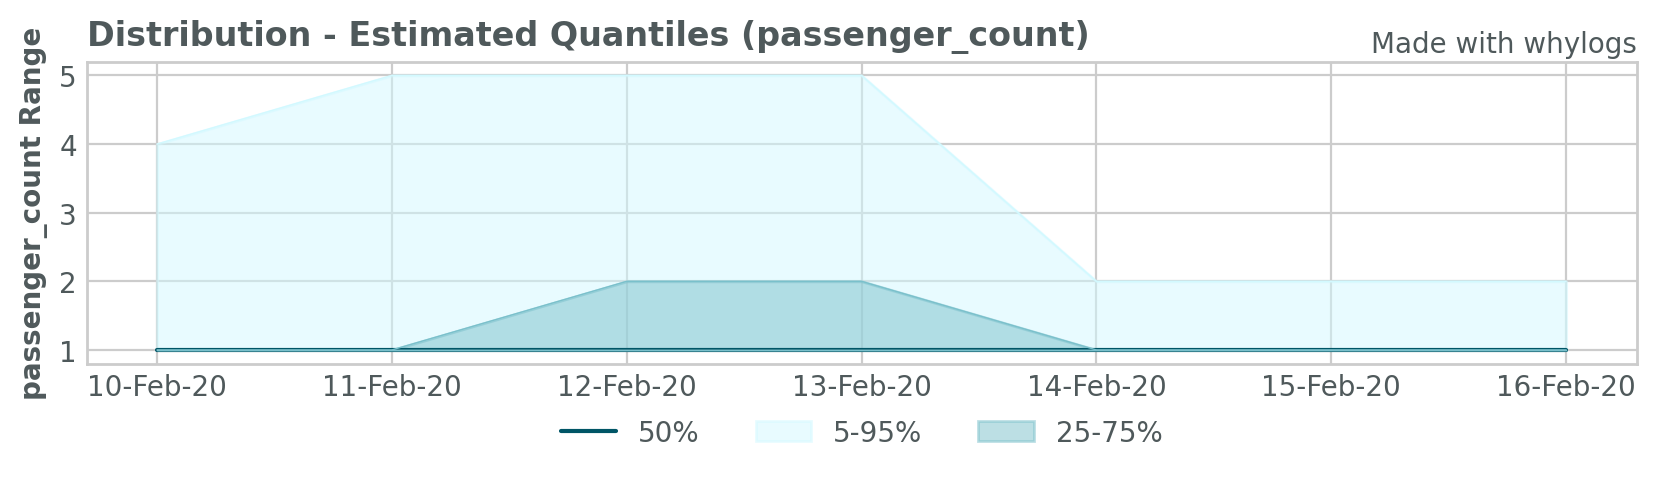

In [ ]:
viz.plot_distribution("passenger_count")

The distribution of number of passengers before Feb 14 doesn't seem to be unconventional. After that, the 5-95% range falls between 1-2 passengers, which is enough to prompt a more detailed investigation.

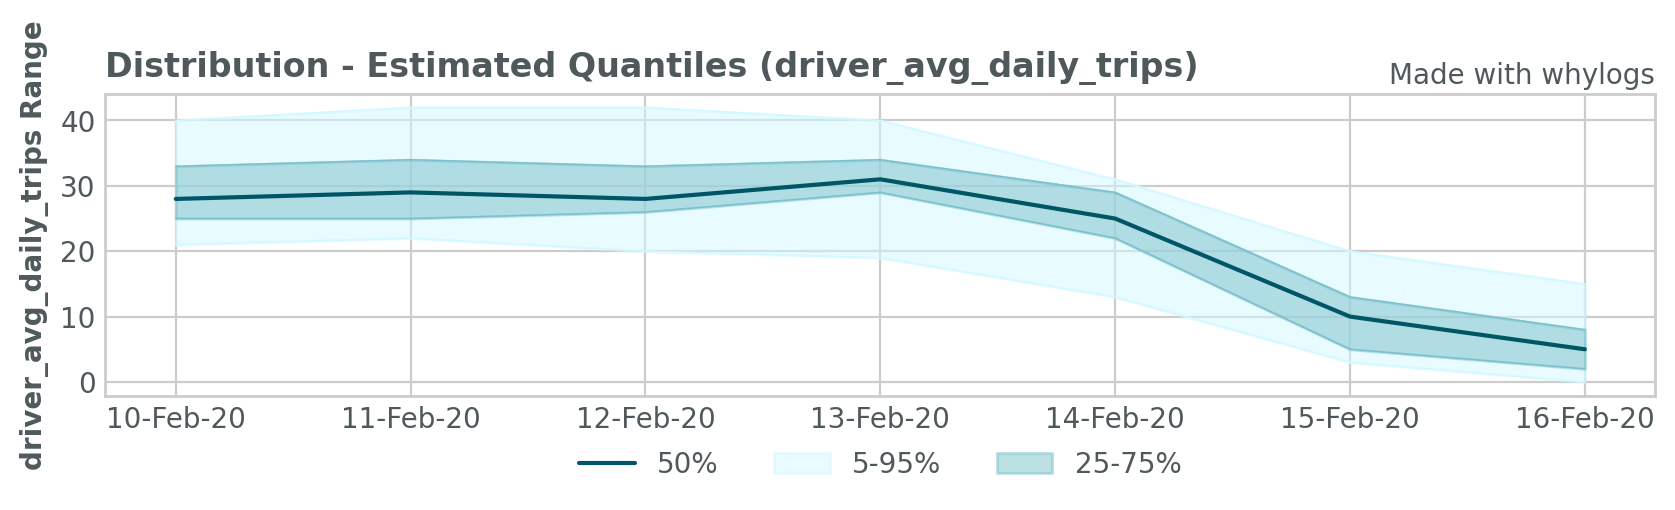

In [ ]:
viz.plot_distribution("driver_avg_daily_trips")

From Feb 14 onwards, as expected, there's a visible reduction in avg daily trips, without much changes in the standard deviation.

02/16/2022 04:30:42 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/16/2022 04:30:42 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana
02/16/2022 04:30:42 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/16/2022 04:30:42 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana
02/16/2022 04:30:42 PM WARNING:findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
02/16/2022 04:30:42 PM WARNING:findfont: Generic family 'sans-serif' not found because none of the following families were found: Asap, Verdana


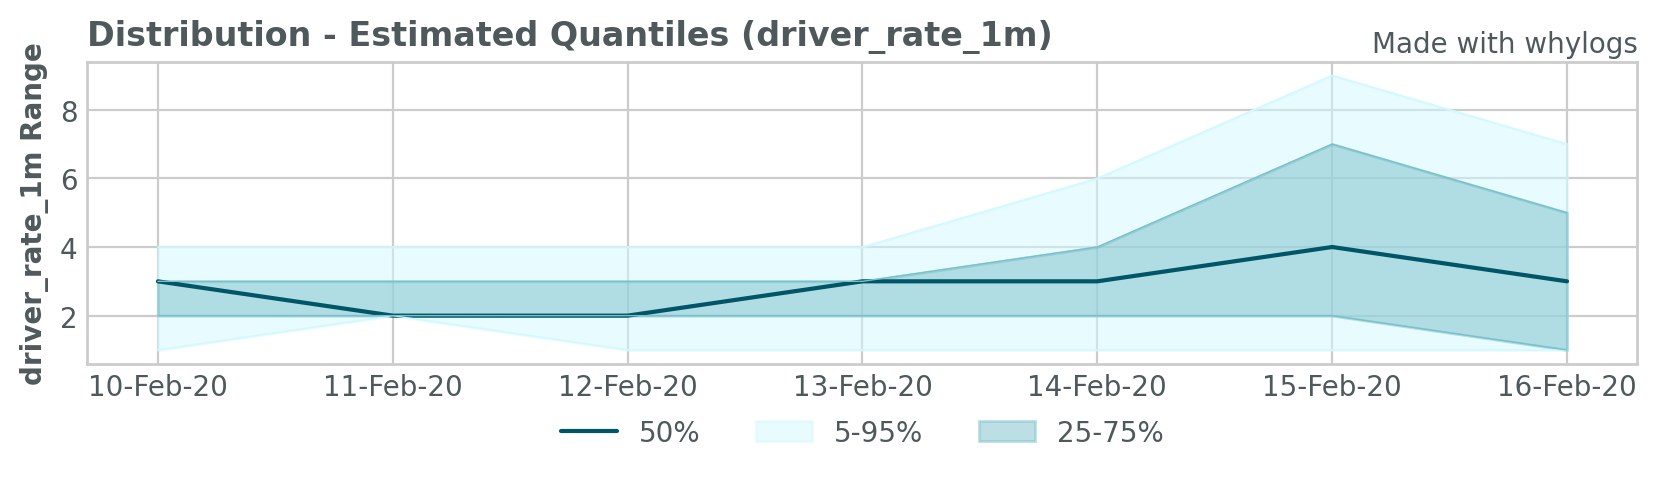

In [ ]:
viz.plot_distribution("driver_rate_1m")

As with the previous plots, the changes injected in `rate_1m` is also visible by plotting the feature's distribution.

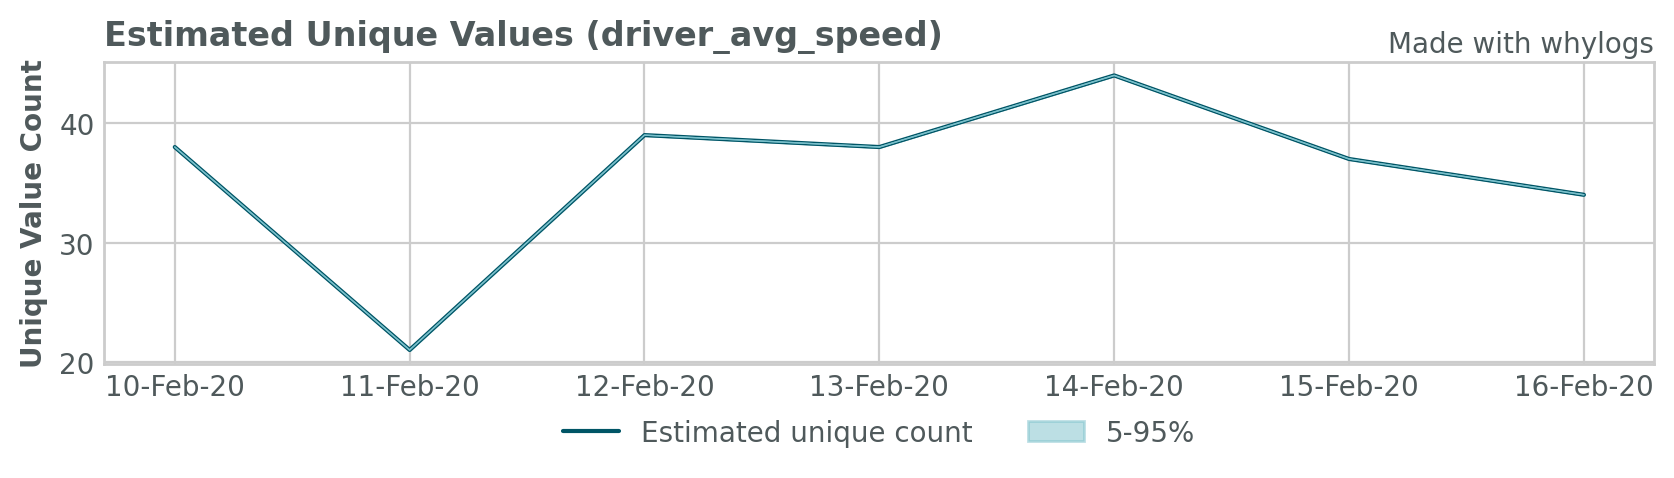

In [ ]:
viz.plot_uniqueness("driver_avg_speed")

Although indirectly, the unique values of `driver_avg_speed` reflect the fact that for Feb 11 we have half the points available of driver statistics and, so, approximately half of unique values for the average speed.

# Appendix - Changing the Dataset

This section is not really a part of the demonstration. It's just to show the changes made in the dataset that originated the `driver_stats_changed.parquet` file that will be used in the beginning of the notebook.

## Driver Statistics

The NYC taxi datasets provides only information about rides, but in this example we want to show an example of using an online feature store to enrich ride information with driver statistics. So, we'll fabricate some driver statistics and link them with the rides dataset  (__nyc_taxi_rides_feb_2020.parquet__) through the `Driver_ID` key.

In [ ]:
import pandas as pd


dstats = pd.DataFrame(
        {'event_timestamp': pd.date_range('2020-02-10', '2020-02-17', freq='1H', closed='left')}
     )
dstats['driver_id'] = '1001'

dstats2 = pd.DataFrame(
        {'event_timestamp': pd.date_range('2020-02-10', '2020-02-17', freq='1H', closed='left')}
     )
dstats2['driver_id'] = '1002'

dstats_tot = pd.concat([dstats, dstats2])

In [ ]:
dstats_tot = dstats_tot.sort_values(by=["event_timestamp","driver_id"])

In [ ]:
import datetime
dstats_tot['created'] = datetime.datetime.now()

In [ ]:
import numpy as np

mu, sigma = 30, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, len(dstats_tot))
daily_trips = np.round(s)
daily_trips = [int(x) for x in daily_trips]
dstats_tot['avg_daily_trips'] = daily_trips

In [ ]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=3, sd=0.75, low=1, upp=11):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

X = get_truncated_normal()

dstats_tot['rate_1m'] = [int(x) for x in X.rvs(len(dstats_tot))]

In [ ]:
import numpy as np

mu, sigma = 20, 4 # mean and standard deviation
s = np.random.normal(mu, sigma, len(dstats_tot))
avg_speed = np.round(s,2)
avg_speed
dstats_tot['avg_speed'] = avg_speed

### Adding changes - Stats Update Frequency

In [ ]:
dstats_tot = dstats_tot.reset_index()
cond = (dstats_tot['event_timestamp'].dt.day==11) & (dstats_tot['event_timestamp'].dt.month==2) & ((dstats_tot['event_timestamp'].dt.hour%2)!=0)
df2 = dstats_tot.loc[cond]
dstats_tot = dstats_tot[~dstats_tot.isin(df2)].dropna()

### Adding changes - Rate_1m

We're assuming that this change in customer's behaviour would not change the mean of the distribution, but would have an increased standard deviation, making the rates be more spreaded, increasing the frequency of extreme ratings (positive or negative).

In [ ]:
import numpy as np
cond = (dstats_tot['event_timestamp'].dt.day==14) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

X = get_truncated_normal(mean=3, sd=2, low=1, upp=11)
rate_1m = [int(x) for x in X.rvs(size)]
dstats_tot.loc[cond, 'rate_1m'] = rate_1m

In [ ]:
import numpy as np
cond = (dstats_tot['event_timestamp'].dt.day==15) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

X = get_truncated_normal(mean=3, sd=3, low=1, upp=11)
rate_1m = [int(x) for x in X.rvs(size)]
dstats_tot.loc[cond, 'rate_1m'] = rate_1m

In [ ]:
import numpy as np
cond = (dstats_tot['event_timestamp'].dt.day==16) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

X = get_truncated_normal(mean=3, sd=4, low=1, upp=11)
rate_1m = [int(x) for x in X.rvs(size)]
dstats_tot.loc[cond, 'rate_1m'] = rate_1m

### Adding Changes - Avg Daily Trips

In [ ]:
cond = (dstats_tot['event_timestamp'].dt.day==14) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

mu, sigma = 24, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, size)
daily_trips = np.round(s)
daily_trips = [int(x) if x>0 else 0 for x in daily_trips]
# daily_trips

dstats_tot.loc[cond, 'avg_daily_trips'] = daily_trips

In [ ]:
cond = (dstats_tot['event_timestamp'].dt.day==15) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

mu, sigma = 12, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, size)
daily_trips = np.round(s)
daily_trips = [int(x) if x>0 else 0 for x in daily_trips]
# daily_trips

dstats_tot.loc[cond, 'avg_daily_trips'] = daily_trips

In [ ]:
cond = (dstats_tot['event_timestamp'].dt.day==16) & (dstats_tot['event_timestamp'].dt.month==2)
size = len(dstats_tot.loc[cond])

mu, sigma = 3, 6 # mean and standard deviation
s = np.random.normal(mu, sigma, size)
daily_trips = np.round(s)
daily_trips = [int(x) if x>0 else 0 for x in daily_trips]
# daily_trips

dstats_tot.loc[cond, 'avg_daily_trips'] = daily_trips

In [ ]:
dstats_tot = dstats_tot.astype({'driver_id': 'int64','avg_daily_trips':'int64','rate_1m':'int64'})
dstats_tot.to_parquet("driver_stats.parquet")

## Rides Dataset

The `nyc_taxi_rides_feb_2020.parquet` was extracted from [the TLC trip record data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). We randomly sampled the data and selected a few chosen features, in order to reduce the dataset for this demonstration.

In addition, one features was created: The day of the week, based from `tpep_pickup_datetime`.

The original features are described in this [data dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

In [ ]:
%cd ..
!ls -R

/work
.:
feature_repo  init.ipynb      nyc_taxi_rides_feb_2020_changed.parquet
images	      notebook.ipynb  nyc_taxi_rides_feb_2020.parquet

./feature_repo:
data  example.py  feature_store.yaml  __init__.py  output

./feature_repo/data:
driver_stats.parquet		 online_store.db
nyc_taxi_rides_feb_2020.parquet  registry.db

./feature_repo/output:
my_dataset

./feature_repo/output/my_dataset:
aa1ffa55-00fa-4da4-b413-b387365fbde4

./feature_repo/output/my_dataset/aa1ffa55-00fa-4da4-b413-b387365fbde4:
flat_table  frequent_strings  histogram  json  protobuf

./feature_repo/output/my_dataset/aa1ffa55-00fa-4da4-b413-b387365fbde4/flat_table:
dataset_profile.csv

./feature_repo/output/my_dataset/aa1ffa55-00fa-4da4-b413-b387365fbde4/frequent_strings:
dataset_profile.json

./feature_repo/output/my_dataset/aa1ffa55-00fa-4da4-b413-b387365fbde4/histogram:
dataset_profile.json

./feature_repo/output/my_dataset/aa1ffa55-00fa-4da4-b413-b387365fbde4/json:
dataset_profile.json

./feature_repo/output/my_data

In [ ]:
import pandas as pd

df_final = pd.read_parquet("nyc_taxi_rides_feb_2020.parquet")

### Reducing Passenger Count

In [ ]:
cond = (df_final['tpep_pickup_datetime'].dt.day==14) & (df_final['tpep_pickup_datetime'].dt.month==2)
df_final.loc[cond, 'passenger_count'] = df_final[cond]['passenger_count'].apply(lambda x: x-1 if x>1 else 1)

cond = (df_final['tpep_pickup_datetime'].dt.day==15) & (df_final['tpep_pickup_datetime'].dt.month==2)
df_final.loc[cond, 'passenger_count'] = df_final[cond]['passenger_count'].apply(lambda x: x-2 if x-2>0 else 1)

cond = (df_final['tpep_pickup_datetime'].dt.day==16) & (df_final['tpep_pickup_datetime'].dt.month==2)
df_final.loc[cond, 'passenger_count'] = df_final[cond]['passenger_count'].apply(lambda x: x-2 if x-2>0 else 1)

In [ ]:
df_final.to_parquet("nyc_taxi_rides_feb_2020_changed.parquet")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=00e43ad4-9473-4fa9-be6f-62af4ce1f0de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>